# Project: Investigate a Dataset (Soccer Database)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Database**: soccer database comes from Kaggle and is well suited for data
analysis and machine learning. It contains data for soccer matches,
players, and teams from several European countries from 2008 to 2016. 

> **Question**:
What team attributes lead to the most victories?

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns


<a id='wrangling'></a>
## Data Wrangling
> * Step0: Observe database, and consider direction of step1 ~ step3
> * Step1: Make "Team_Points" table by season using "Match" table
    * Drop unuse columns
    * Separate  Match table to home team record and away team record
    * Match columns name in 2 tables (in home team record table,home_team_api_id > team_api_id ,away_team_api_id > opponent_team_api_id...) 
    * Concatrate home team record and away team record
    * Make new column named "points", and  add data ("win" is 3,"draw" is 1,"lose" is 0)
    * Make "Team_Points" table grouped by team_api_id and season,sumarize "points"
> * Step2: Clean up "Team Attribute" table
    * Drop columns other than id,date,Categorical data
    * Make new columns named "Season" by "date"(and drop "date" column)
> * Step3: Join tables
    * Merge Team Attribute table and "Team_Points" table on "Season" and "team_api_id"

In [2]:
# read data
dbname = "database.sqlite"
connect = sqlite3.connect(dbname)
tablenames = ["Country","League","Match","Player","Player_Attributes","Team","Team_Attributes"]

datum = {}
for tablename in tablenames:
    sql_query = "SELECT * FROM " + tablename
    df = pd.read_sql(sql_query,connect)
    datum[tablename] = df

datum["Country"]

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


### Step0:Observe database, and consider direction of step1 ~ step3

In [3]:
df_match = datum["Match"]
df_match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


* "Match" table has no information about "win or lose"
* To analyze which team attributes important factor, we need to separete "Match" table to home and away

In [4]:
df_match.shape

(25979, 115)

* "Match" table has many columns

In [5]:
df_match.isnull().sum()

id                      0
country_id              0
league_id               0
season                  0
stage                   0
date                    0
match_api_id            0
home_team_api_id        0
away_team_api_id        0
home_team_goal          0
away_team_goal          0
home_player_X1       1821
home_player_X2       1821
home_player_X3       1832
home_player_X4       1832
home_player_X5       1832
home_player_X6       1832
home_player_X7       1832
home_player_X8       1832
home_player_X9       1832
home_player_X10      1832
home_player_X11      1832
away_player_X1       1832
away_player_X2       1832
away_player_X3       1832
away_player_X4       1832
away_player_X5       1832
away_player_X6       1832
away_player_X7       1832
away_player_X8       1832
                    ...  
B365H                3387
B365D                3387
B365A                3387
BWH                  3404
BWD                  3404
BWA                  3404
IWH                  3459
IWD         

* Many columns contains NA
* Because we analyze team attributes in this notebook, we need drop unused columns

In [6]:
df_team = datum["Team"]
df_team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


* Team has 2 ids (team_api_id,team_fifa_api_id)

In [7]:
df_team.isnull().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

* Team_fifa_api_id has NA,so we should use team_api_id as key

In [8]:
df_teamattr = datum["Team_Attributes"]
df_teamattr.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


* In this dataset, One attribute seems represented by categorical and continuous

In [9]:
df_teamattr.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

* "buildUpPlayDribbling" contains a lot of null
* Leave the defects in this phase and consider the meaning of the defects in the search phase

In [10]:
team_api_id = df_team[df_team.team_long_name.str.contains("Barcelona")].team_api_id.values[0]
df_teamattr[df_teamattr.team_api_id==team_api_id]

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
118,119,241,8634,2010-02-22 00:00:00,42,Balanced,NaN,Little,30,Short,...,70,Lots,Free Form,70,High,30,Contain,70,Wide,Offside Trap
119,120,241,8634,2011-02-22 00:00:00,43,Balanced,NaN,Little,34,Mixed,...,68,Lots,Free Form,67,High,43,Press,68,Wide,Cover
120,121,241,8634,2012-02-22 00:00:00,24,Slow,NaN,Little,25,Short,...,54,Normal,Free Form,66,Medium,63,Press,66,Normal,Cover
121,122,241,8634,2013-09-20 00:00:00,35,Balanced,NaN,Little,32,Short,...,35,Normal,Free Form,61,Medium,63,Press,65,Normal,Cover
122,123,241,8634,2014-09-19 00:00:00,35,Balanced,35.0,Normal,32,Short,...,35,Normal,Free Form,61,Medium,63,Press,65,Normal,Cover
123,124,241,8634,2015-09-10 00:00:00,36,Balanced,35.0,Normal,51,Mixed,...,56,Normal,Free Form,61,Medium,65,Press,65,Normal,Cover


* Team attributes seems updated by seasons

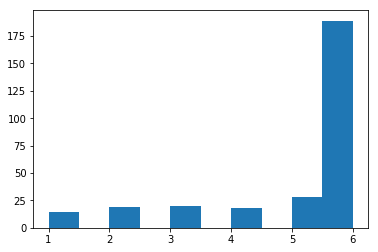

In [11]:
plt.hist(df_teamattr.team_api_id.value_counts());

* Most teams have attributes for 6 seasons

### Step1: Make "Team_Points" table by seasons using "Match" table

In [12]:
# Drop unuse columns of Match table
df_match2 = df_match[["season","home_team_api_id","away_team_api_id","home_team_goal","away_team_goal"]]
df_match2

,season,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,2008/2009,9987,9993,1,1
1,2008/2009,10000,9994,0,0
2,2008/2009,9984,8635,0,3
3,2008/2009,9991,9998,5,0
4,2008/2009,7947,9985,1,3
5,2008/2009,8203,8342,1,1
6,2008/2009,9999,8571,2,2
7,2008/2009,4049,9996,1,2
8,2008/2009,10001,9986,1,0
9,2008/2009,8342,8571,4,1


In [13]:
#Separate Match table to home team record and away team record
df_match_home = df_match2.copy()
df_match_away = df_match2.copy()

In [14]:
#rename columns name in home table
rename_home = {"home_team_api_id":"team_api_id",
               "away_team_api_id":"opponent_team_api_id",
               "home_team_goal":"goal_scored",
               "away_team_goal":"goal_conceded"}
df_match_home = df_match_home.rename(columns=rename_home)
df_match_home

,season,team_api_id,opponent_team_api_id,goal_scored,goal_conceded
0,2008/2009,9987,9993,1,1
1,2008/2009,10000,9994,0,0
2,2008/2009,9984,8635,0,3
3,2008/2009,9991,9998,5,0
4,2008/2009,7947,9985,1,3
5,2008/2009,8203,8342,1,1
6,2008/2009,9999,8571,2,2
7,2008/2009,4049,9996,1,2
8,2008/2009,10001,9986,1,0
9,2008/2009,8342,8571,4,1


In [15]:
#rename columns name in away table
rename_away = {"home_team_api_id":"opponent_team_api_id",
               "away_team_api_id":"team_api_id",
               "home_team_goal":"goal_conceded",
               "away_team_goal":"goal_scored"}
df_match_away = df_match_away.rename(columns=rename_away)
df_match_away

,season,opponent_team_api_id,team_api_id,goal_conceded,goal_scored
0,2008/2009,9987,9993,1,1
1,2008/2009,10000,9994,0,0
2,2008/2009,9984,8635,0,3
3,2008/2009,9991,9998,5,0
4,2008/2009,7947,9985,1,3
5,2008/2009,8203,8342,1,1
6,2008/2009,9999,8571,2,2
7,2008/2009,4049,9996,1,2
8,2008/2009,10001,9986,1,0
9,2008/2009,8342,8571,4,1


In [16]:
#Concatrate home team record and away team record
df_record = pd.concat([df_match_home,df_match_away]).reset_index(drop=True)
df_record

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,goal_conceded,goal_scored,opponent_team_api_id,season,team_api_id
0,1,1,9993,2008/2009,9987
1,0,0,9994,2008/2009,10000
2,3,0,8635,2008/2009,9984
3,0,5,9998,2008/2009,9991
4,3,1,9985,2008/2009,7947
5,1,1,8342,2008/2009,8203
6,2,2,8571,2008/2009,9999
7,2,1,9996,2008/2009,4049
8,0,1,9986,2008/2009,10001
9,1,4,8571,2008/2009,8342


In [17]:
#Make new column named "points", and add data ("win" is 3,"draw" is 1,"lose" is 0)
df_record.loc[df_record.goal_scored>df_record.goal_conceded,"points"]=3
df_record.loc[df_record.goal_scored==df_record.goal_conceded,"points"]=1
df_record.loc[df_record.goal_scored<df_record.goal_conceded,"points"]=0
df_record[["goal_scored","goal_conceded","points"]]

,goal_scored,goal_conceded,points
0,1,1,1.0
1,0,0,1.0
2,0,3,0.0
3,5,0,3.0
4,1,3,0.0
5,1,1,1.0
6,2,2,1.0
7,1,2,0.0
8,1,0,3.0
9,4,1,3.0


In [18]:
#Make "Team_Points" table grouped by team_api_id and season,sumarize "points"
df_team_points = df_record.groupby(["team_api_id","season"])["points"].sum().reset_index()
df_team_points

,team_api_id,season,points
0,1601,2008/2009,34.0
1,1601,2009/2010,53.0
2,1601,2010/2011,38.0
3,1601,2011/2012,55.0
4,1601,2012/2013,31.0
5,1601,2013/2014,50.0
6,1601,2014/2015,33.0
7,1601,2015/2016,39.0
8,1773,2011/2012,29.0
9,1773,2012/2013,36.0


### Step2: Clean up "Team Attribute" table

In [19]:
#Drop columns other than id,date,Categorical data
#df_teamattr2 = pd.concat([df_teamattr[["team_api_id"]],
#                          df_teamattr.select_dtypes("object")],
#                         axis=1)
df_teamattr2 = df_teamattr.drop(["id","team_fifa_api_id"],axis=1)
df_teamattr2
          

,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover
5,8485,2012-02-22 00:00:00,58,Balanced,NaN,Little,62,Mixed,Organised,45,...,55,Normal,Organised,40,Medium,40,Press,60,Normal,Cover
6,8485,2013-09-20 00:00:00,62,Balanced,NaN,Little,45,Mixed,Organised,40,...,55,Normal,Organised,42,Medium,42,Press,60,Normal,Cover
7,8485,2014-09-19 00:00:00,58,Balanced,64.0,Normal,62,Mixed,Organised,56,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,8485,2015-09-10 00:00:00,59,Balanced,64.0,Normal,53,Mixed,Organised,51,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
9,8576,2010-02-22 00:00:00,60,Balanced,NaN,Little,40,Mixed,Organised,45,...,55,Normal,Organised,30,Deep,70,Double,30,Narrow,Offside Trap


In [20]:
#Make new columns named "season" by "date"
df_teamattr2.date = pd.to_datetime(df_teamattr2.date)
month = df_teamattr2.date.dt.month
year = df_teamattr2.date.dt.year
last_year = year-1
next_year = year+1
df_teamattr2.loc[(month>=8)&(month<=12),"season"]=year.astype("str")+"/"+next_year.astype("str")
df_teamattr2.loc[(month>=1)&(month<=7),"season"]=last_year.astype("str")+"/"+year.astype("str")
df_teamattr2[["date","season"]]

,date,season
0,2010-02-22,2009/2010
1,2014-09-19,2014/2015
2,2015-09-10,2015/2016
3,2010-02-22,2009/2010
4,2011-02-22,2010/2011
5,2012-02-22,2011/2012
6,2013-09-20,2013/2014
7,2014-09-19,2014/2015
8,2015-09-10,2015/2016
9,2010-02-22,2009/2010


In [21]:
#drop "date" column
df_teamattr2 = df_teamattr2.drop("date",axis=1)
df_teamattr2

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,season
0,9930,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,...,Normal,Organised,50,Medium,55,Press,45,Normal,Cover,2009/2010
1,9930,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,...,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,2014/2015
2,9930,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,...,Normal,Organised,47,Medium,44,Press,54,Normal,Cover,2015/2016
3,8485,70,Fast,NaN,Little,70,Long,Organised,70,Risky,...,Lots,Organised,60,Medium,70,Double,70,Wide,Cover,2009/2010
4,8485,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,...,Normal,Organised,47,Medium,47,Press,52,Normal,Cover,2010/2011
5,8485,58,Balanced,NaN,Little,62,Mixed,Organised,45,Normal,...,Normal,Organised,40,Medium,40,Press,60,Normal,Cover,2011/2012
6,8485,62,Balanced,NaN,Little,45,Mixed,Organised,40,Normal,...,Normal,Organised,42,Medium,42,Press,60,Normal,Cover,2013/2014
7,8485,58,Balanced,64.0,Normal,62,Mixed,Organised,56,Normal,...,Normal,Organised,41,Medium,42,Press,60,Normal,Cover,2014/2015
8,8485,59,Balanced,64.0,Normal,53,Mixed,Organised,51,Normal,...,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover,2015/2016
9,8576,60,Balanced,NaN,Little,40,Mixed,Organised,45,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Offside Trap,2009/2010


### Step3: Join tables

In [22]:
#Merge Team Attribute table and "Team_Points" table on "Season" and "team_api_id"
df = pd.merge(df_teamattr2,df_team_points,how="left",on=["team_api_id","season"])
df

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,season,points
0,9930,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,...,Organised,50,Medium,55,Press,45,Normal,Cover,2009/2010,23.0
1,9930,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,...,Organised,47,Medium,44,Press,54,Normal,Cover,2014/2015,30.0
2,9930,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,...,Organised,47,Medium,44,Press,54,Normal,Cover,2015/2016,NaN
3,8485,70,Fast,NaN,Little,70,Long,Organised,70,Risky,...,Organised,60,Medium,70,Double,70,Wide,Cover,2009/2010,41.0
4,8485,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,...,Organised,47,Medium,47,Press,52,Normal,Cover,2010/2011,38.0
5,8485,58,Balanced,NaN,Little,62,Mixed,Organised,45,Normal,...,Organised,40,Medium,40,Press,60,Normal,Cover,2011/2012,41.0
6,8485,62,Balanced,NaN,Little,45,Mixed,Organised,40,Normal,...,Organised,42,Medium,42,Press,60,Normal,Cover,2013/2014,68.0
7,8485,58,Balanced,64.0,Normal,62,Mixed,Organised,56,Normal,...,Organised,41,Medium,42,Press,60,Normal,Cover,2014/2015,75.0
8,8485,59,Balanced,64.0,Normal,53,Mixed,Organised,51,Normal,...,Free Form,49,Medium,45,Press,63,Normal,Cover,2015/2016,71.0
9,8576,60,Balanced,NaN,Little,40,Mixed,Organised,45,Normal,...,Organised,30,Deep,70,Double,30,Narrow,Offside Trap,2009/2010,NaN


In [23]:
df.isnull().sum()

team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
season                              0
points                            390
dtype: int64

In [24]:
#drop NA
df = df[~df.points.isnull()].reset_index(drop=True)
df

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,season,points
0,9930,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,...,Organised,50,Medium,55,Press,45,Normal,Cover,2009/2010,23.0
1,9930,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,...,Organised,47,Medium,44,Press,54,Normal,Cover,2014/2015,30.0
2,8485,70,Fast,NaN,Little,70,Long,Organised,70,Risky,...,Organised,60,Medium,70,Double,70,Wide,Cover,2009/2010,41.0
3,8485,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,...,Organised,47,Medium,47,Press,52,Normal,Cover,2010/2011,38.0
4,8485,58,Balanced,NaN,Little,62,Mixed,Organised,45,Normal,...,Organised,40,Medium,40,Press,60,Normal,Cover,2011/2012,41.0
5,8485,62,Balanced,NaN,Little,45,Mixed,Organised,40,Normal,...,Organised,42,Medium,42,Press,60,Normal,Cover,2013/2014,68.0
6,8485,58,Balanced,64.0,Normal,62,Mixed,Organised,56,Normal,...,Organised,41,Medium,42,Press,60,Normal,Cover,2014/2015,75.0
7,8485,59,Balanced,64.0,Normal,53,Mixed,Organised,51,Normal,...,Free Form,49,Medium,45,Press,63,Normal,Cover,2015/2016,71.0
8,8576,59,Balanced,NaN,Little,52,Mixed,Organised,48,Normal,...,Organised,38,Medium,47,Press,53,Normal,Cover,2011/2012,41.0
9,8576,59,Balanced,NaN,Little,52,Mixed,Organised,48,Normal,...,Organised,38,Medium,47,Press,53,Normal,Cover,2013/2014,23.0


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (What team attributes lead to the most victories?)

In [25]:
df.points.describe()

count    1068.000000
mean       48.600187
std        16.162491
min         4.000000
25%        38.000000
50%        46.000000
75%        58.000000
max       102.000000
Name: points, dtype: float64

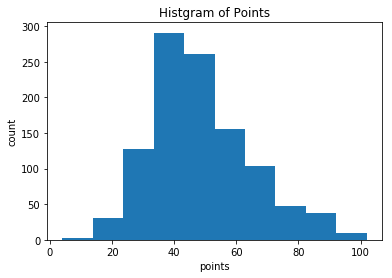

In [26]:
plt.figure()
plt.title("Histgram of Points")
plt.xlabel("points")
plt.ylabel("count")
plt.hist(df.points);

* It seems little bit right skewed

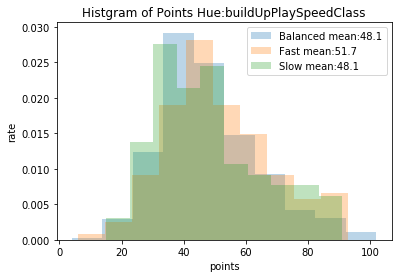

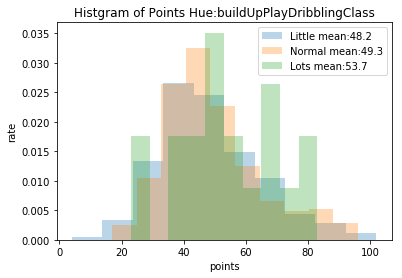

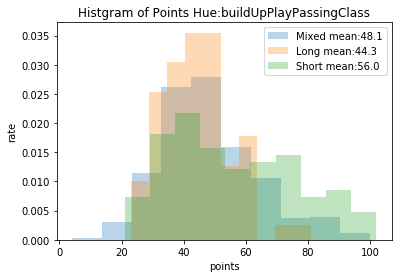

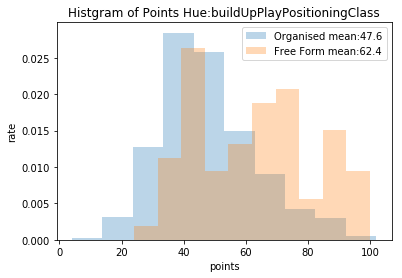

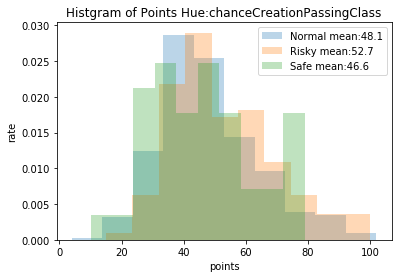

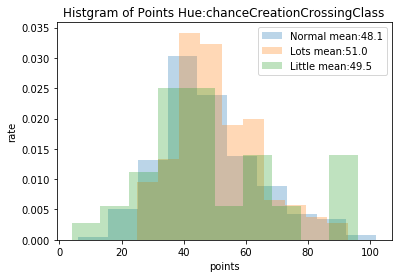

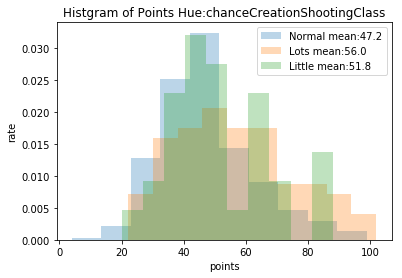

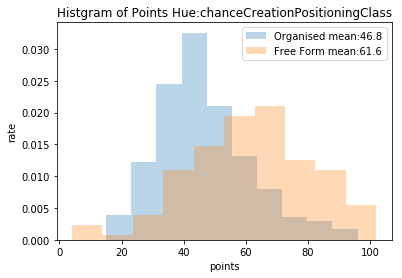

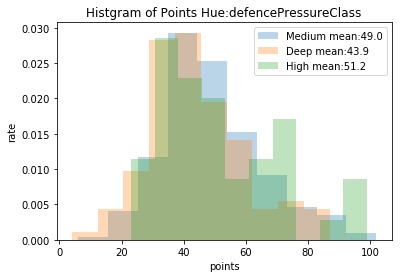

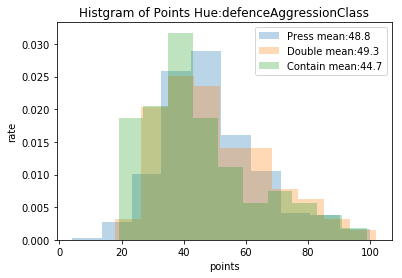

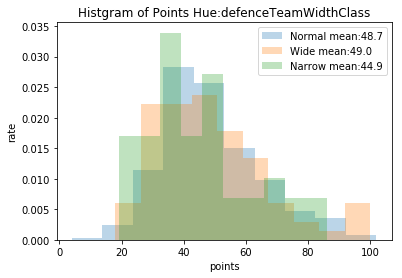

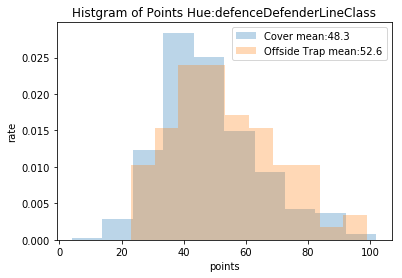

In [27]:
target_columns = [column for column in df.select_dtypes("object").columns if column is not "season"]
for column in target_columns:
    plt.figure()
    plt.title("Histgram of Points Hue:"+column)
    for category in df[column].unique():
        df_tmp = df[df[column]==category]
        plt.hist(df_tmp.points,
                 label=category+" mean:" + "{:.1f}".format(df_tmp.points.mean()),
                 alpha=0.3,
                 density=True)
        plt.xlabel("points")
        plt.ylabel("rate")
    plt.legend();
    

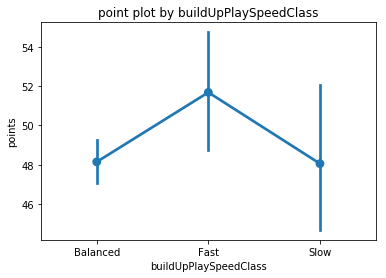

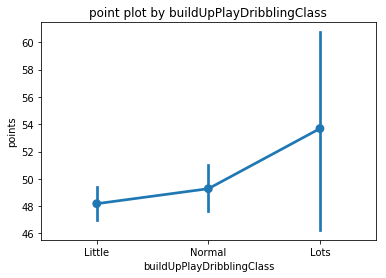

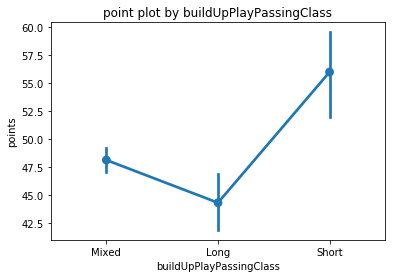

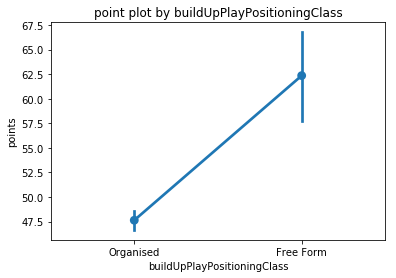

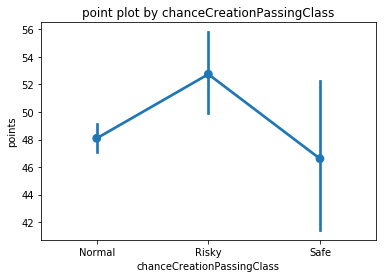

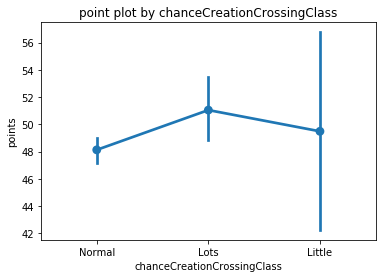

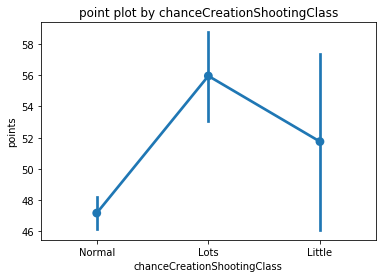

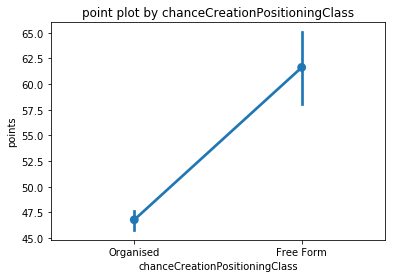

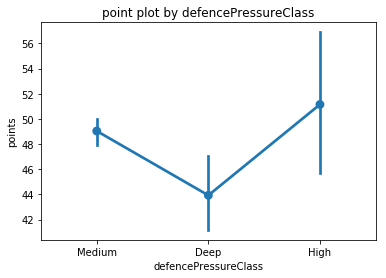

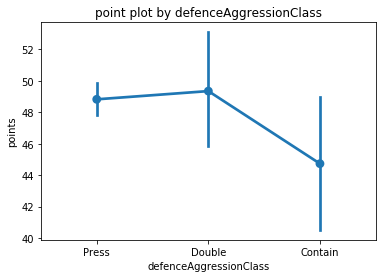

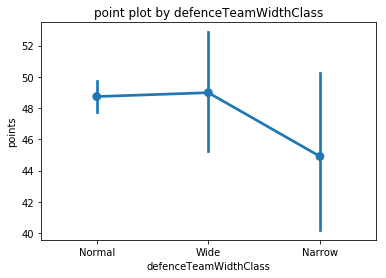

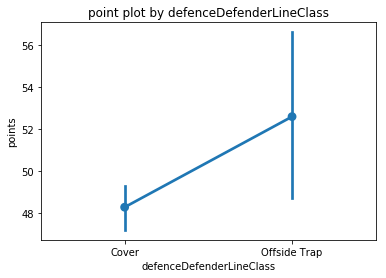

In [28]:
for column in target_columns:
    plt.figure()
    sns.pointplot(data=df, x=column, y='points')
    plt.title("point plot by "+column);

In [41]:
np.corrcoef(x=df[column],y=df["points"])[0][1]

0.088394594432335535

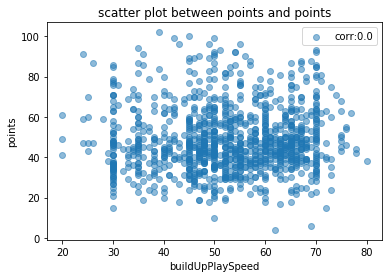

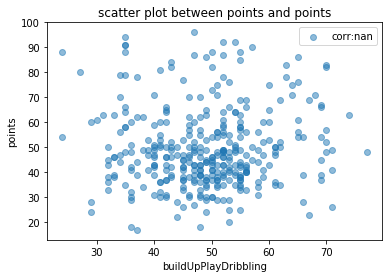

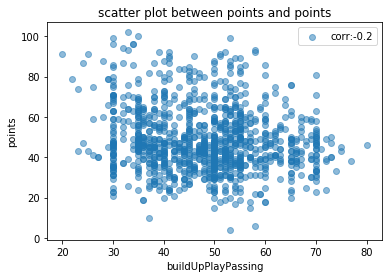

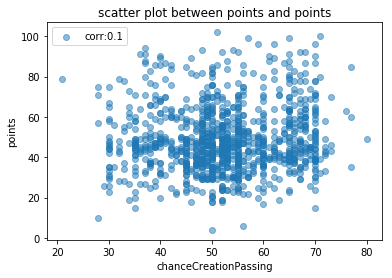

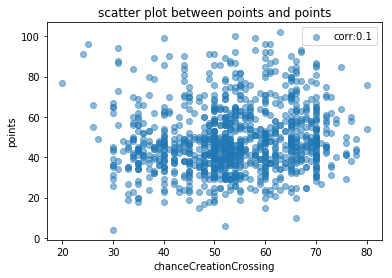

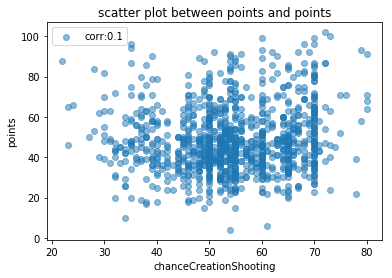

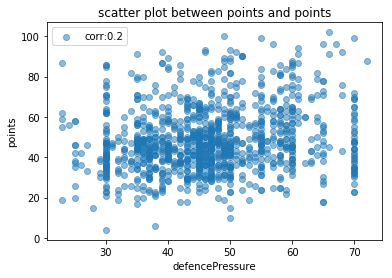

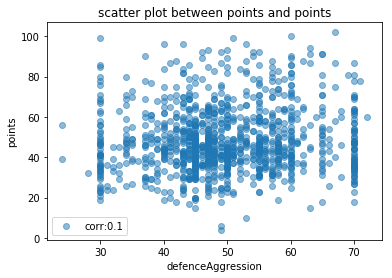

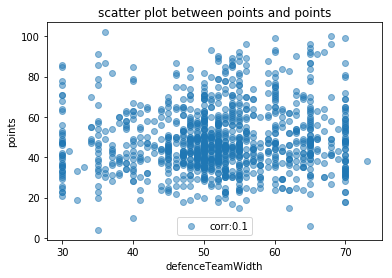

In [43]:
numeric_columns = [column for column in df.select_dtypes(["float","int"]).columns if column not in ["team_api_id","points"]]
for column in numeric_columns:
    plt.figure()
    corr = np.corrcoef(x=df[column],y=df["points"])[0][1]
    plt.title("scatter plot between points and " + columns )
    label = ("corr:" + "{:.1f}".format(corr))
    plt.scatter(x=df[column],y=df["points"],alpha=0.5,label=label)
    plt.xlabel(column)
    plt.ylabel("points")
    plt.legend();

* Variables with large difference are as follows:
    * buildUpPlayPositioningClass ("Free Form" teams tend to get more points than "Organised")
    * chanceCreationPositioningClass ("Free Form" teams tend to get more points than "Organised")
    * buildUpPlayPassingClass ("Short" teams tend to get more points than "Mixed" and "Long")
    

### Research Question 2  (How team attirbutes trends are changing?)

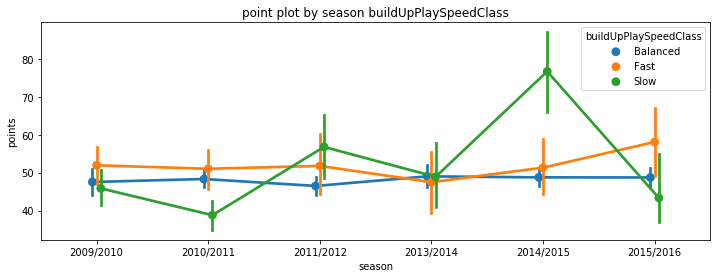

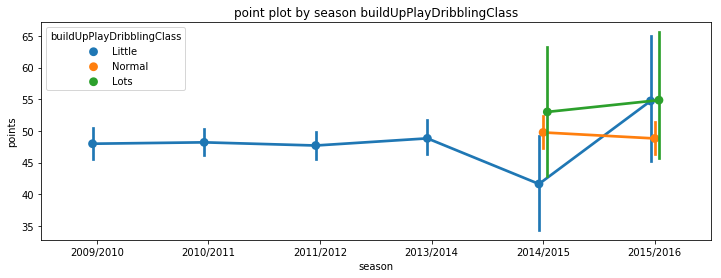

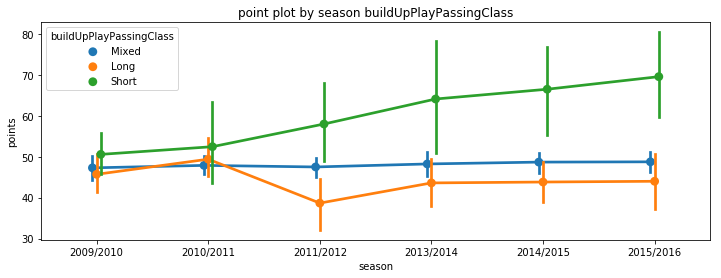

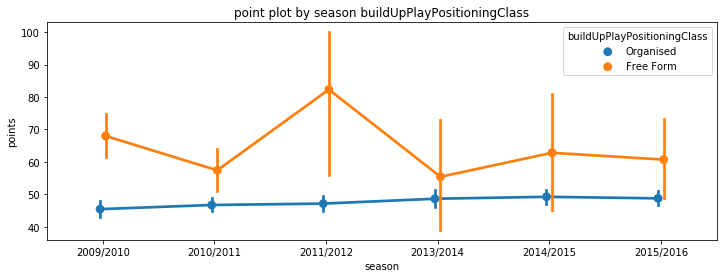

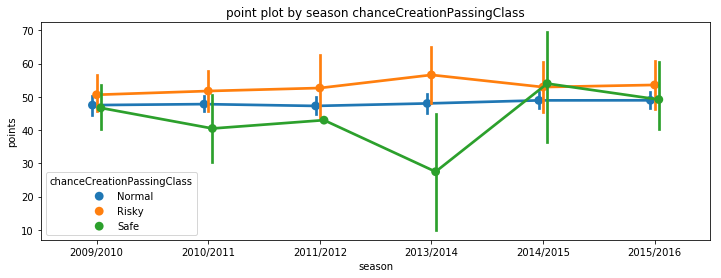

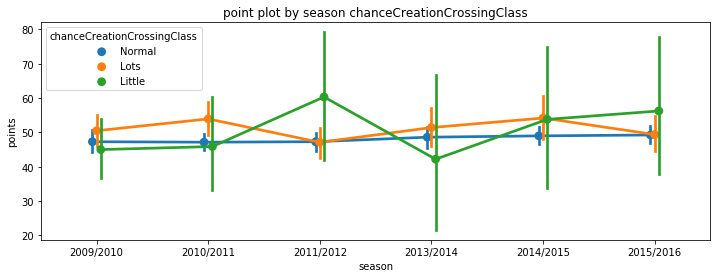

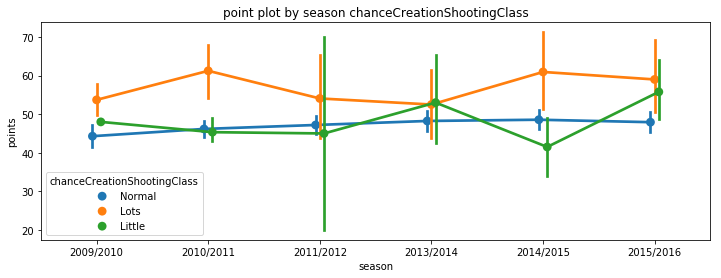

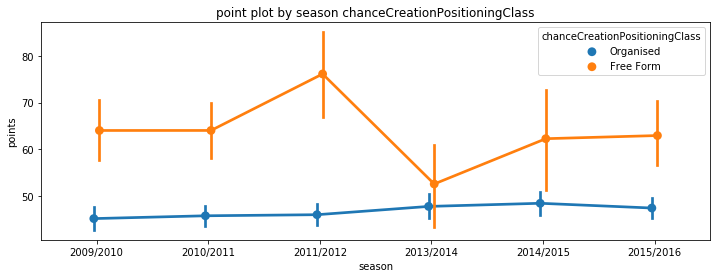

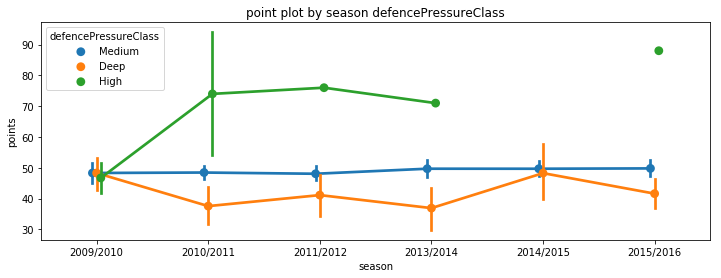

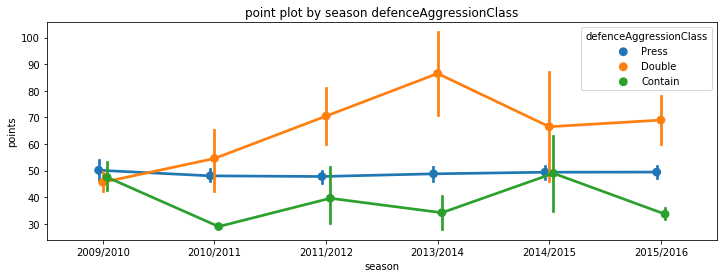

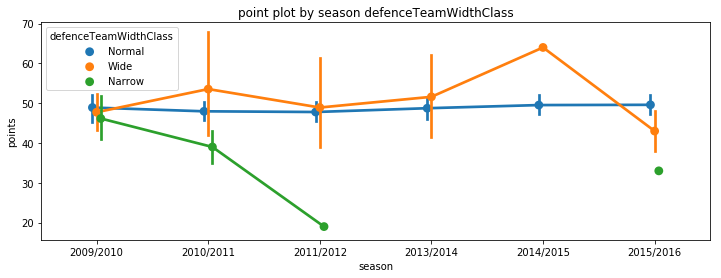

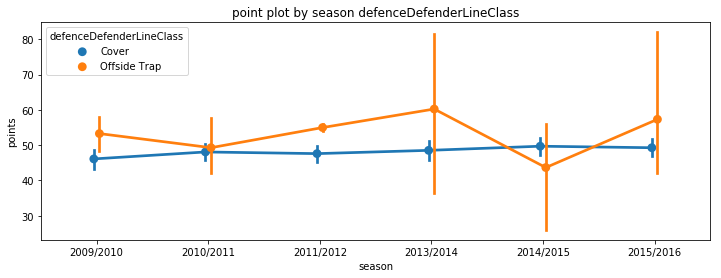

In [29]:
for column in target_columns:
    plt.figure(figsize=(12,4))
    plt.title("point plot by season "+column)    
    sns.pointplot(data=df, x='season', y='points',hue=column,dodge=True,order=sorted(df["season"].unique()));

* "Short pass"  teams tend to get more points team year by year
* "Free build up and chance making" teams  get more points than others in most seasons without 2012/2013, and 2011/2021 season is peak of  these attributes
* High pressure and double aggression defense seem to contribute win more and more since 2010/2011

<a id='conclusions'></a>
## Conclusions

* As a result of exploratory data analysis, the following trends were observed
> * Since 2010/2011 season to 2015/2016,free formed building up and chance making seems to stronger than organized.
> * Until 2015/2016 season, Building up by short pass is important more and more.
> * Until 2015/2016 season, defensive attributes is important more and more.

### Limitations
* We have not done hypothesis test and not reached statistically significant conclusions yet
* The team attributes has a value only once every year, so We assumed the value was that of season (in fact, values of  attributes  can fluctuate at any time during the season)
* Because the above results are based on data from the 2009/2010 to 2015/16 season, At this time (2020/2021), the same tendency may not be seen
* Due to analysis using Europa League data, it may not apply to other regions(eg.Asia)

In [30]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0